In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
# featuretools for automated feature engineering
import math

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
# plt.rcParams['font.size'] = 22

plt.rc('font', family='NanumBarunGothic') 
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

import imblearn
from imblearn.under_sampling import RandomUnderSampler
sns.set_style("darkgrid")
# memory management
import gc

In [ ]:
# import os
# # 운영체제별 한글 폰트 설정
# if os.name == 'posix': # Mac 환경 폰트 설정
#     plt.rc('font', family='AppleGothic')
# elif os.name == 'nt': # Windows 환경 폰트 설정
#     plt.rc('font', family='Malgun Gothic')

# plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset2.csv")

In [ ]:
non = data.loc[data["당뇨여부"] == 0]
yess = data.loc[data["당뇨여부"] == 1]

new = pd.concat([non, yess])
new.reset_index(drop=True,inplace=True)
data = new.copy()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
  
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

In [ ]:
def doTest(X):
  y = data.loc[:, ["당뇨여부"]]
  rus = RandomUnderSampler(sampling_strategy=0.8)
  X_rus, y_rus = rus.fit_resample(X, y)

  X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, stratify = y_rus, test_size=0.2 ,shuffle=True, random_state=58)


  forest = RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=2, n_estimators=1000, n_jobs=-1, random_state=58)

  # forest = RandomForestClassifier(n_estimators = 300, random_state = 42, max_features=5)
  
  forest.fit(X_train, y_train)
  
  predict = forest.predict(X_test)
  (tn, fp, fn, tp) = confusion_matrix(y_test, predict).ravel()
  


  accuracy = metrics.accuracy_score(y_test, predict)
  fpr = fp / (tn + fp) # fall out 당뇨 아닌 놈을 당뇨라고 하는 비율
  precision = tp / (tp+fp)
  recall = tp / (tp+fn)
  f_score = (precision * recall * 2) / (precision + recall)
  random_forest_proba = forest.predict_proba(X_test)[:, 1]

  

  print('Accuracy: ', accuracy)
  print('Fall out: ', fpr)
  print('Precision: ', precision)
  print('Recall: ', recall)
  print('F-Score: ', f_score)




  roc_curve_plot(y_test, random_forest_proba)
  roc_auc = metrics.roc_auc_score(y_test, random_forest_proba)

  print('AUC-score: {0:.5f}'.format(roc_auc))



Accuracy:  0.7084585659081151
Fall out:  0.2765135251180764
Precision:  0.6661482633488854
Recall:  0.6896736796908545
F-Score:  0.6777068720004219


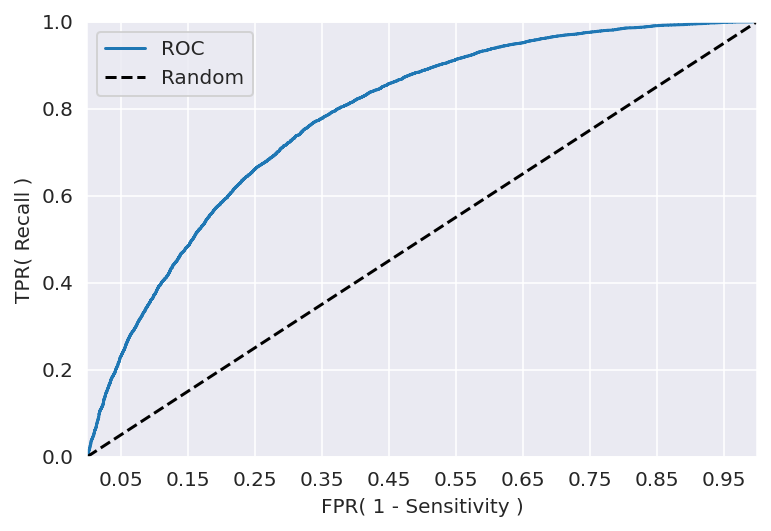

AUC-score: 0.78151


In [ ]:
tmp = data.drop(["당뇨여부", "식전혈당(공복혈당)"], axis=1)
X = tmp.loc[:, ["허리둘레", "연령대코드(5세단위)", "감마지티피", "LDL콜레스테롤", "트리글리세라이드", "총콜레스테롤", "수축기혈압","(혈청지오티)ALT"]]
# X = tmp.loc[:, ["허리둘레", "연령대코드(5세단위)", "감마지티피", "LDL콜레스테롤", "트리글리세라이드"]]

y = data.loc[:, ["당뇨여부"]]
# rus = RandomUnderSampler(sampling_strategy=0.8)
# X_rus, y_rus = rus.fit_resample(X, y)

# X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, stratify = y_rus, test_size=0.2 ,shuffle=True, random_state=42)

# from sklearn.model_selection import GridSearchCV

# params = {
#     'max_depth': [5, 10],
#     'min_samples_leaf': [1,5, 10],
#     'min_samples_split': [2],
# }

# rf_clf = RandomForestClassifier(n_estimators=200, random_state = 42, n_jobs = -1)
# grid_cv = GridSearchCV(rf_clf,
#                        param_grid = params,
#                        cv = 3, 
#                        n_jobs = -1)

# grid_cv.fit(X_train, y_train)

# print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
# print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

doTest(X)

Feature Importance

In [ ]:
forest = RandomForestClassifier(n_estimators = 300, random_state = 42, max_features=5)

forest.fit(X_train, y_train)
importance = forest.feature_importances_
n_feature = X.shape[1]

index = np.arange(n_feature)

forest.fit(X_train, y_train)

plt.barh(index, forest.feature_importances_, align='center')

plt.yticks(index, X.columns)

plt.ylim(-1, n_feature)

plt.xlabel('feature importance', size=15)

plt.ylabel('feature', size=15)

plt.show()

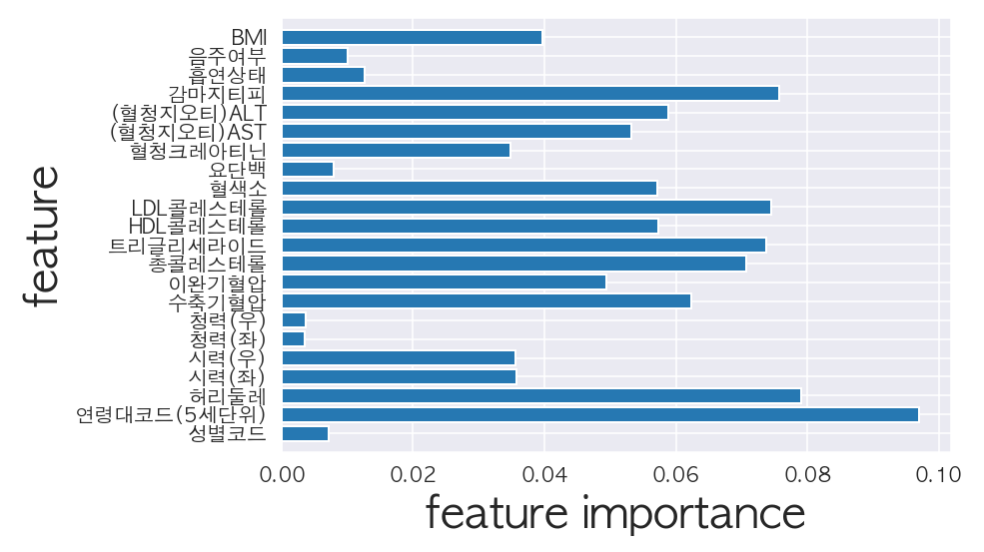

Parameter Tuning

In [ ]:
rus = RandomUnderSampler(sampling_strategy=0.8)
X_rus, y_rus = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, stratify = y_rus, test_size=0.2 ,shuffle=True, random_state=42)

from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [5, 10],
    'min_samples_leaf': [1,5, 10],
    'min_samples_split': [2],
}

rf_clf = RandomForestClassifier(n_estimators=200, random_state = 42, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf,
                       param_grid = params,
                       cv = 3, 
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

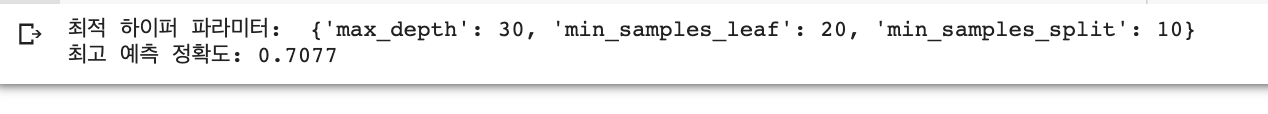

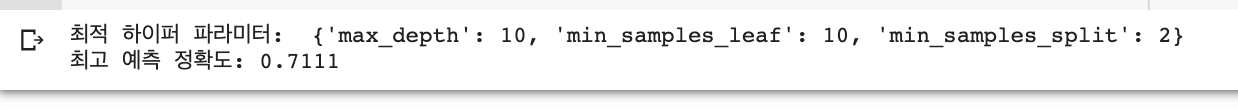

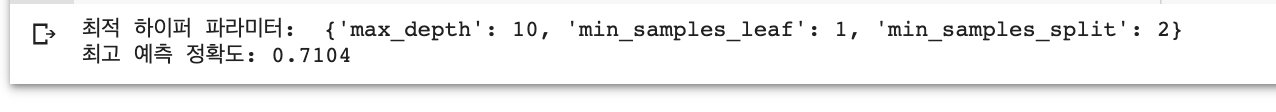

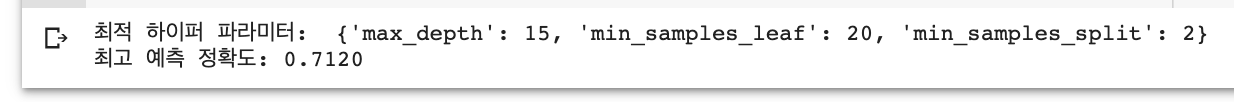

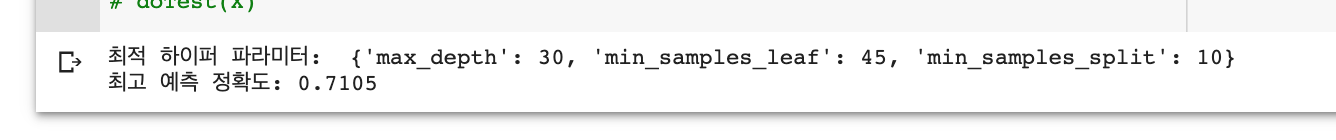

Set 1
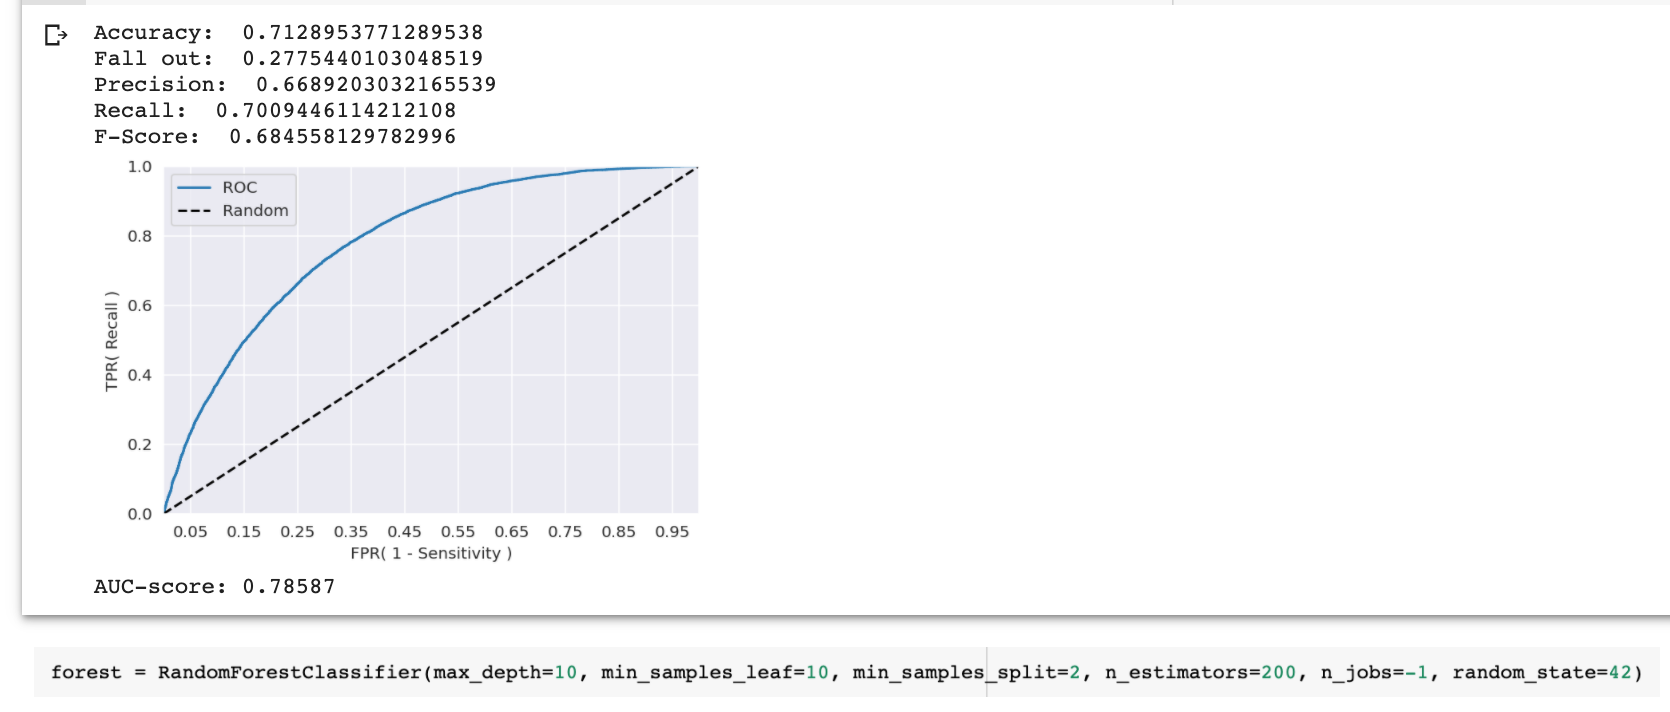

Set 2
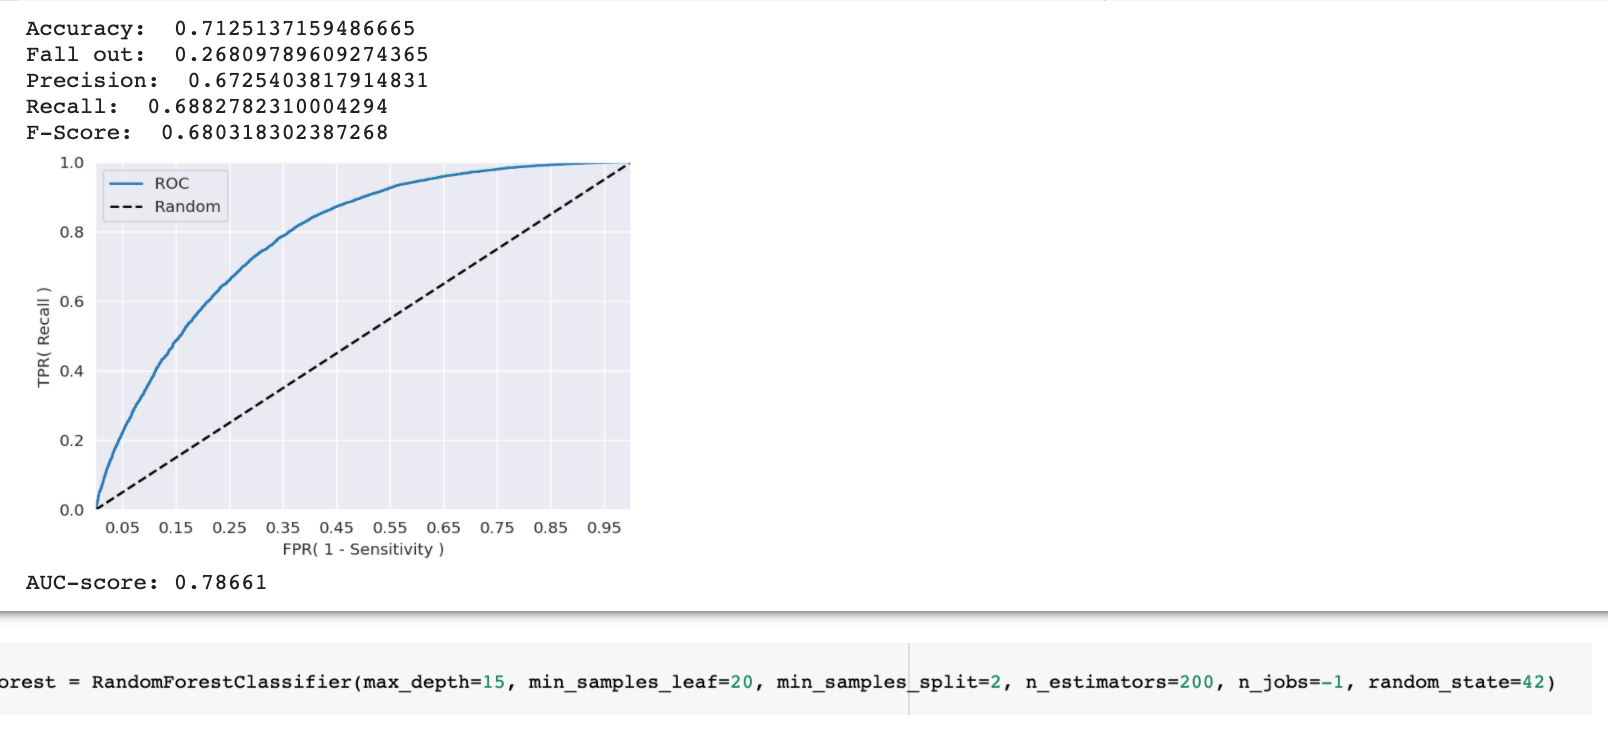

Set 3
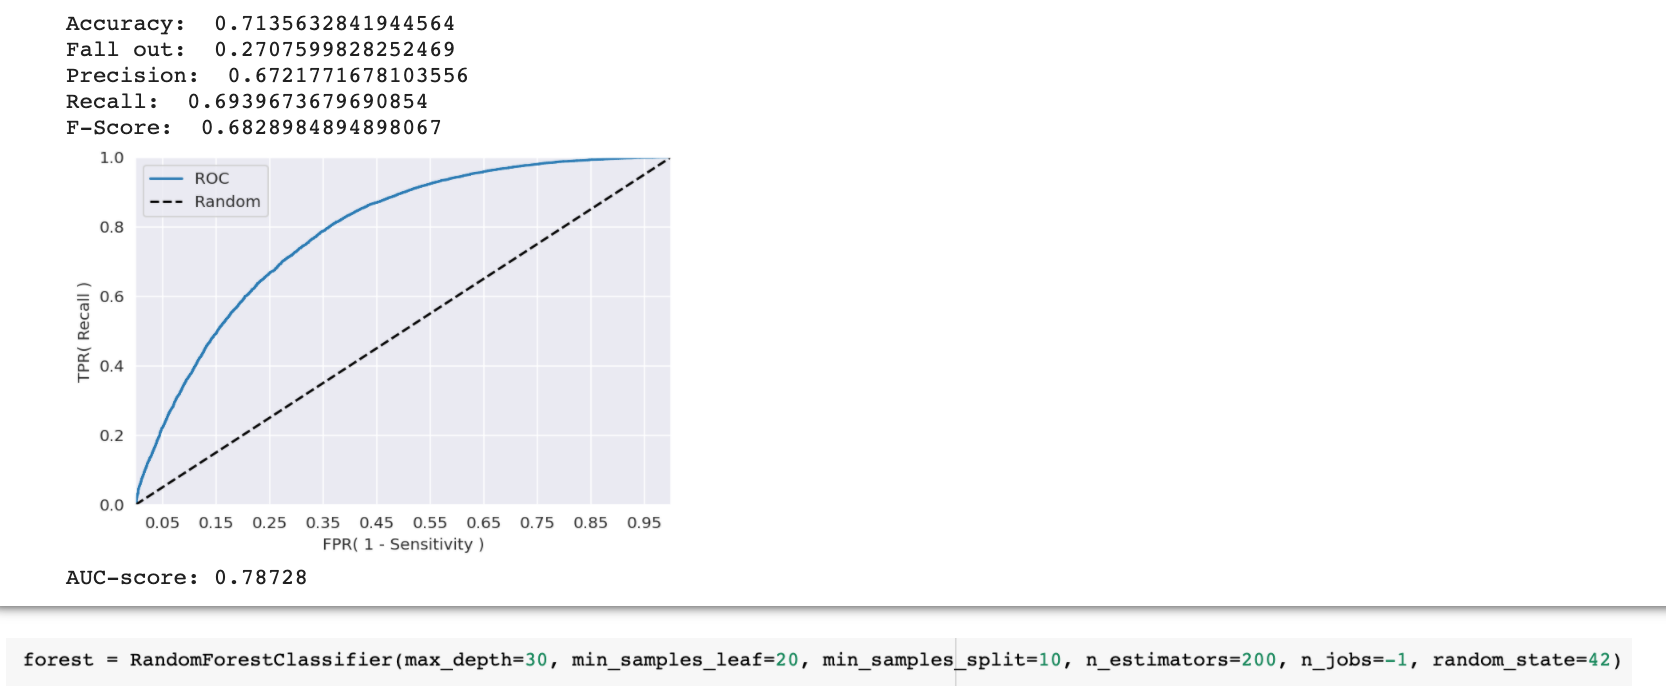

Set 4
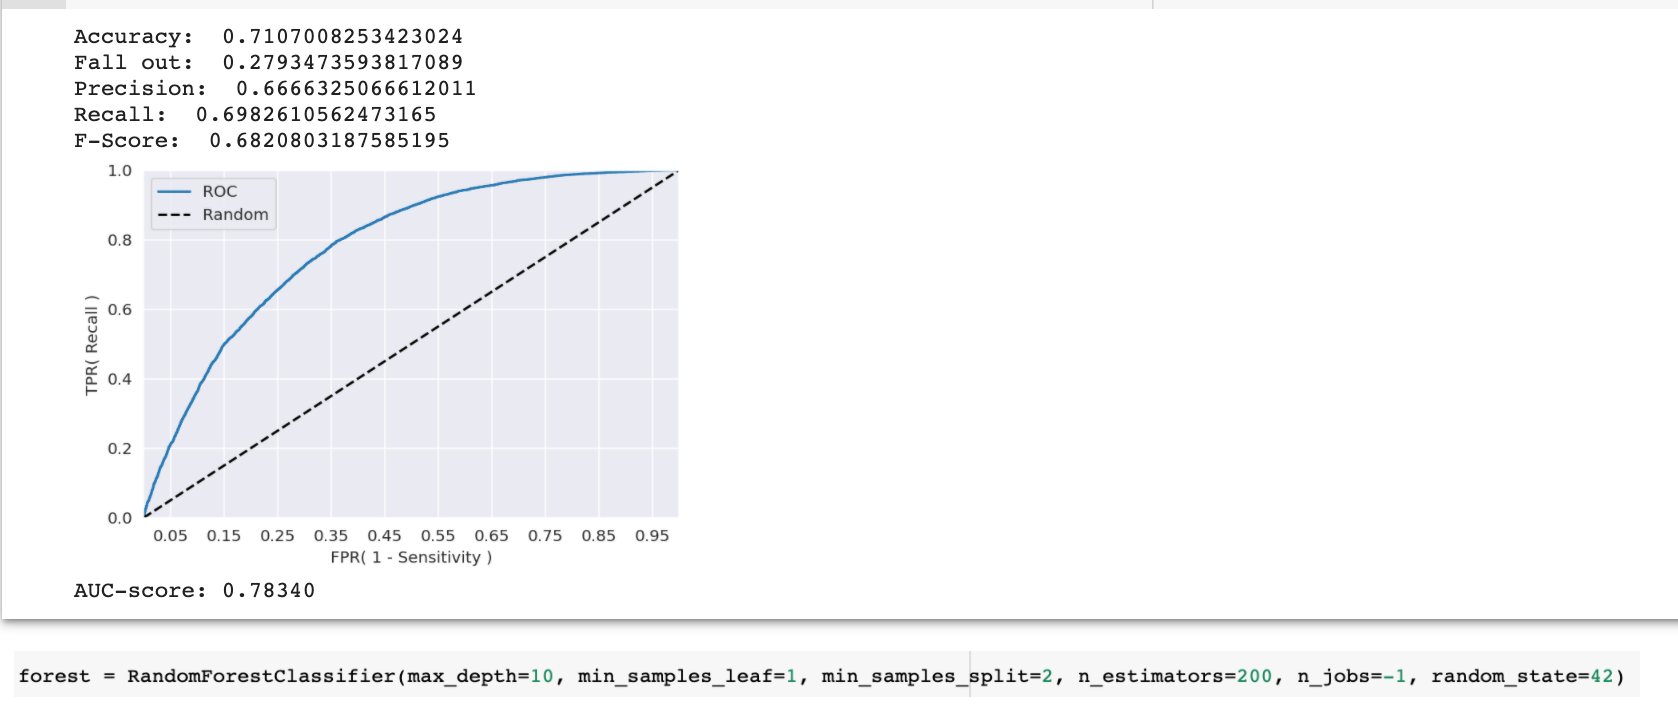

Set 5
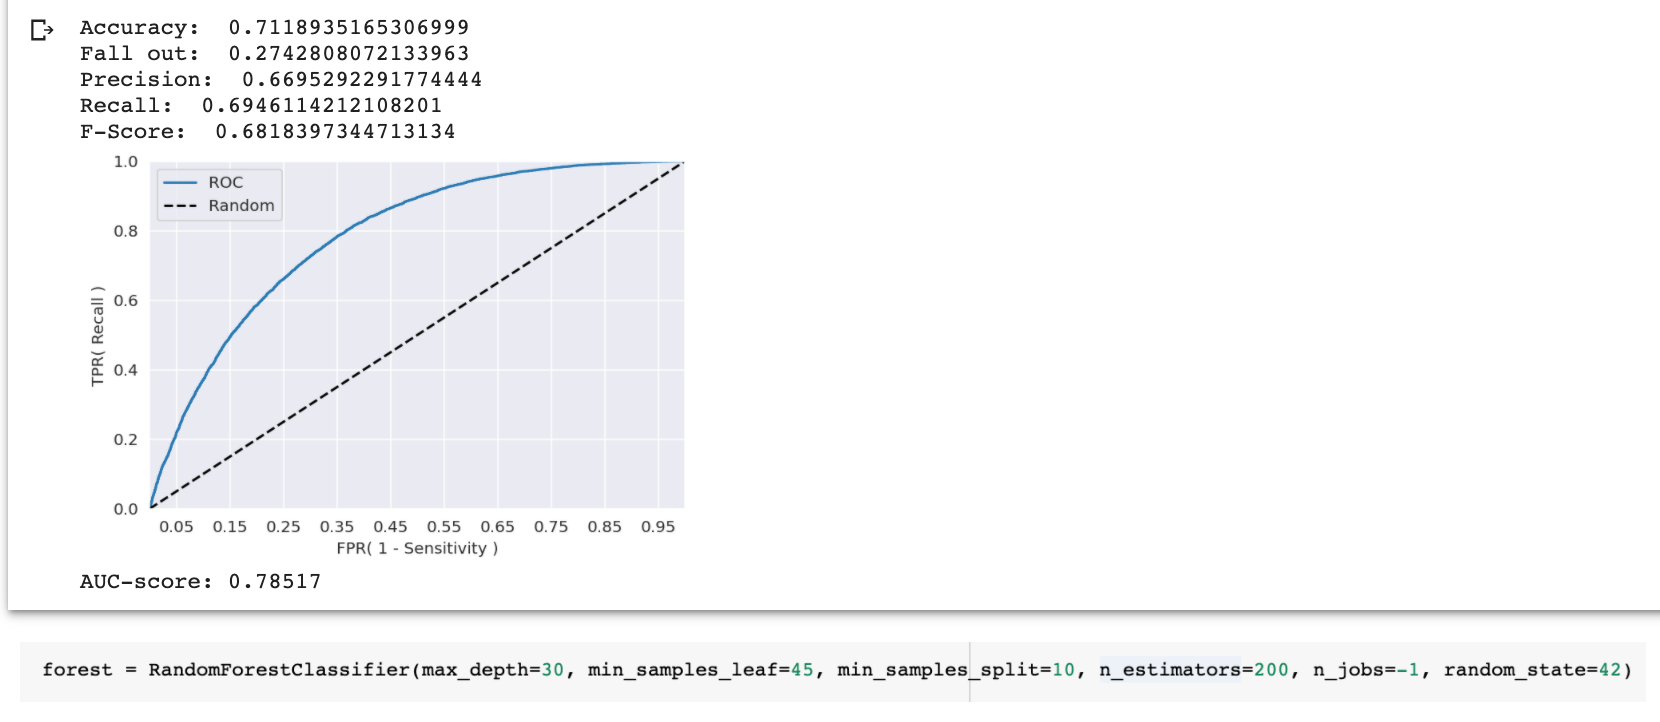

Set 6
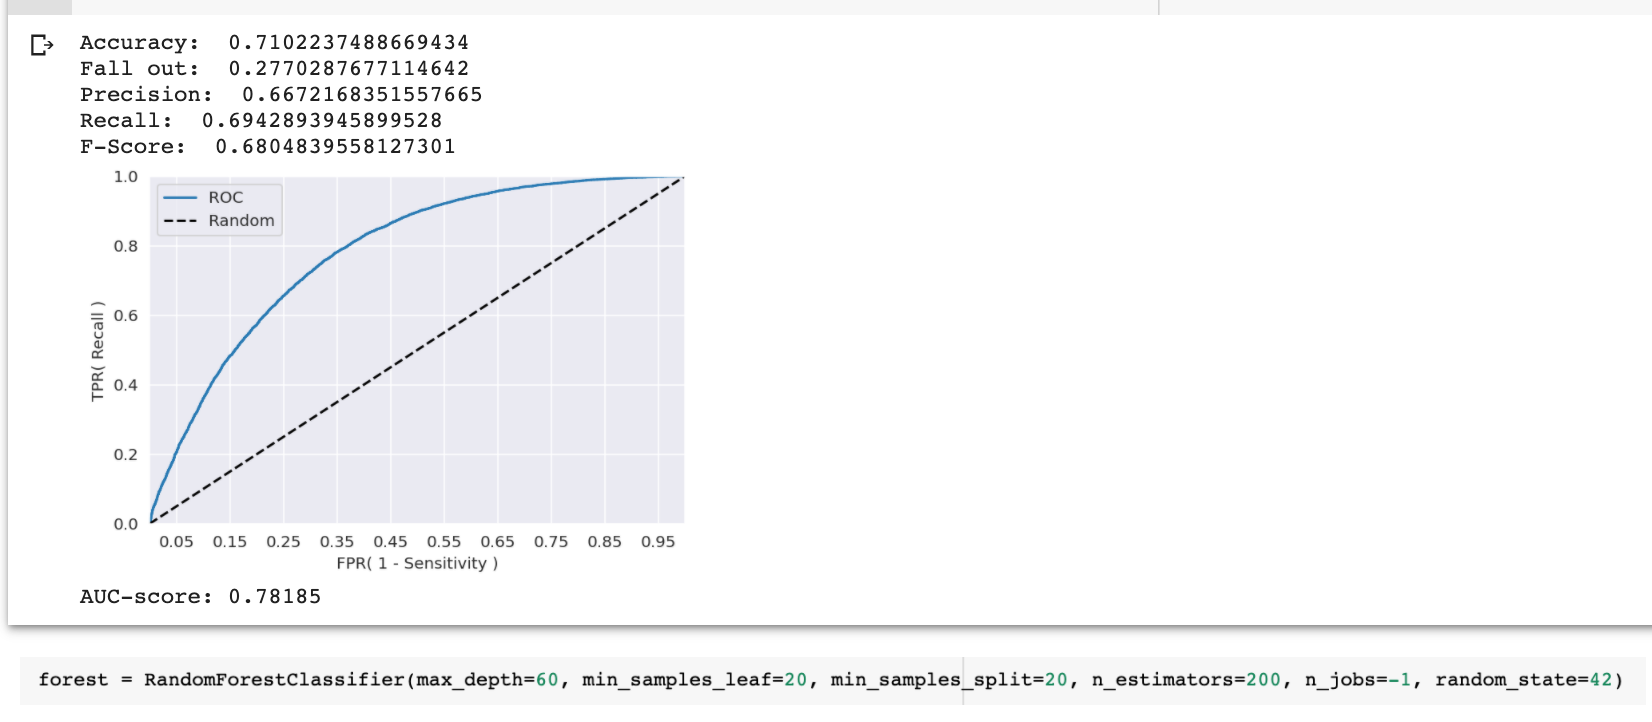

Increased n_estimator
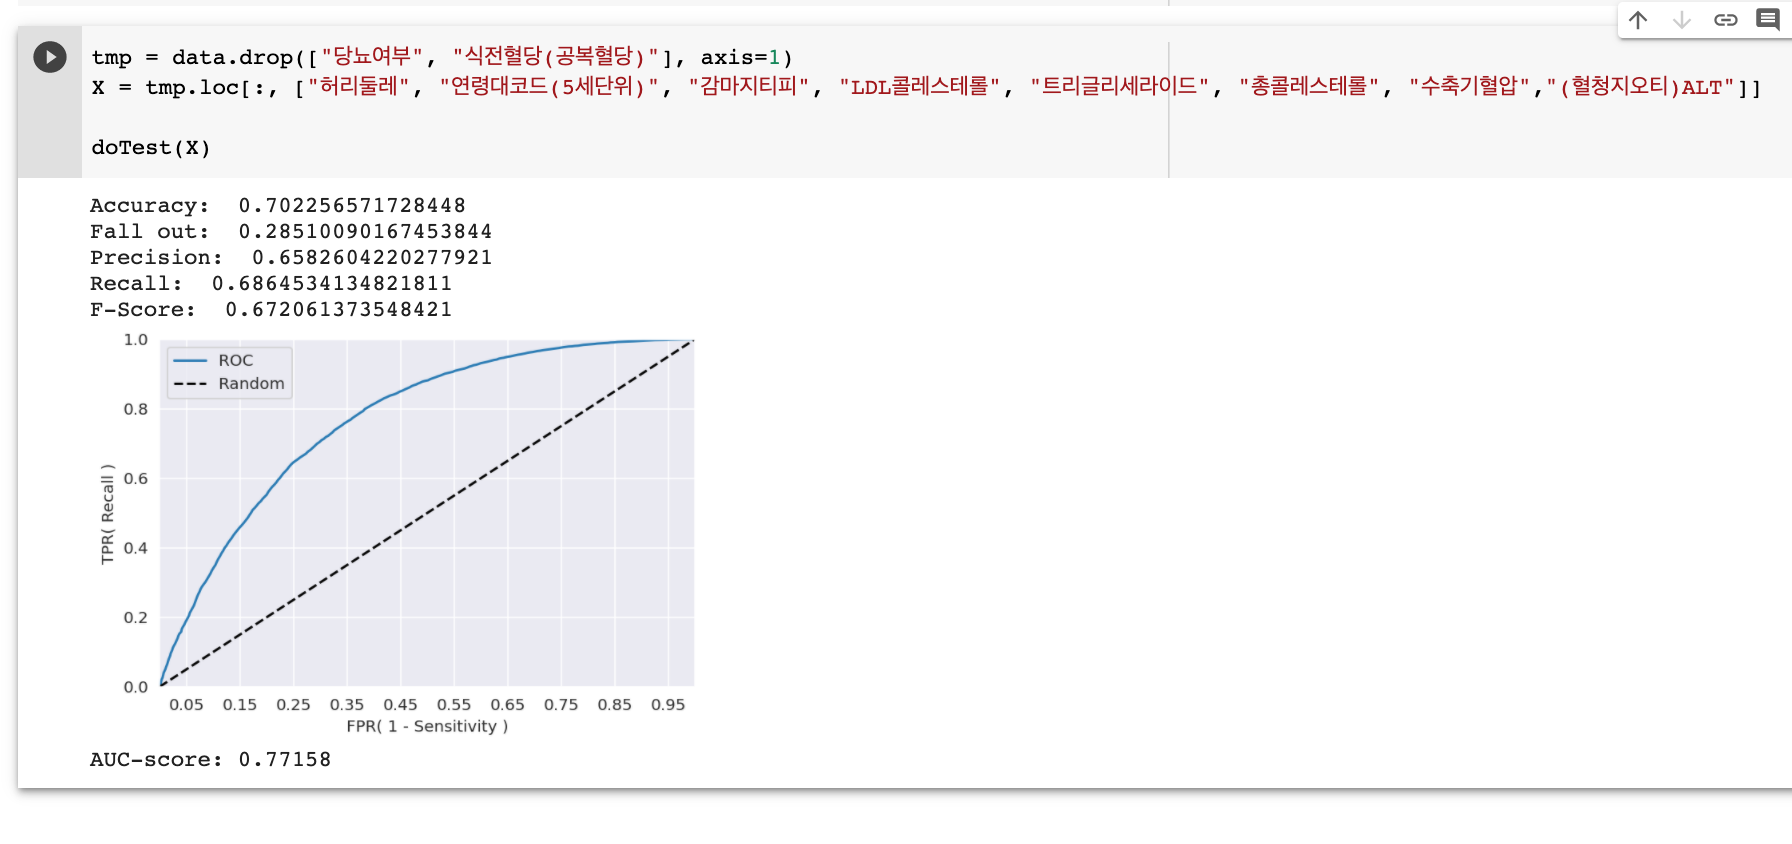